In [1]:
from general_utils import *
from own_utils import *

Notebook general setup done.
Notebook general setup done.
Notebook own setup done.


In [37]:
# Corrector code

steps = 20
EbN0_dB = np.linspace(1, 9, steps)
EbN0 = 10**(EbN0_dB/10)  # Convert to linear scale

EbfN0 = EbN0 * n/k
EbfN0_dB = 10 * np.log10(EbfN0)

# Simulate error rates for coded and uncoded system, with error correction
source_ber = np.zeros(steps)  # Source bit error rate
coded_wer = np.zeros(steps)  # Coded word error rate
uncoded_ber = np.zeros(steps)  # Uncoded bit error rate

for i, ebf_n0 in enumerate(EbfN0):
    trials = 10 / (0.5 * erfc(np.sqrt(ebf_n0))) # Thumbnail rule to reach a good approximation with dynamic trials
    print("trials(ebf_n0)", ebf_n0, trials)

    source_messages = np.random.randint(0, 2, (int(trials), k), dtype=np.uint8)

    uncoded_received = noisy_channel(source_messages, n=k, k=k, EbfN0=ebf_n0)
    uncoded_bit_errors = np.sum(source_messages != uncoded_received, axis=1).astype(float)
    uncoded_bit_errors /= k

    encoded_messages = np.array([encode_message(msg, G) for msg in source_messages])
    received_codewords = noisy_channel(encoded_messages, n=n, k=k, EbfN0=ebf_n0)
    
    decoded_messages = decode_message(received_codewords, H, n)

    bit_errors = np.sum(source_messages != decoded_messages[:, :k], axis=1).astype(float)
    bit_errors /= k

    word_errors = np.any(encoded_messages != received_codewords, axis=1).astype(float)
    
    # Average the results over all trials
    source_ber[i] = np.mean(bit_errors)
    coded_wer[i] = np.mean(word_errors)
    uncoded_ber[i] = np.mean(uncoded_bit_errors)

trials(ebf_n0) 1.7624955765118344 330.851134473953
trials(ebf_n0) 1.9419287829912992 410.236044169057
trials(ebf_n0) 2.1396294257222768 518.4010687132098
trials(ebf_n0) 2.357457245350048 668.8504022556381
trials(ebf_n0) 2.597461315889947 882.8866945648482
trials(ebf_n0) 2.8618993200629324 1194.994170738075
trials(ebf_n0) 3.153258786982335 1662.5809270458594
trials(ebf_n0) 3.474280491971556 2384.1686180313386
trials(ebf_n0) 3.827984238631327 3534.517650834822
trials(ebf_n0) 4.217697265684624 5434.974110221974
trials(ebf_n0) 4.647085545818208 8700.034911156876
trials(ebf_n0) 5.120188270944359 14556.0897991658
trials(ebf_n0) 5.64145584828056 25567.674606878045
trials(ebf_n0) 6.215791764670597 47378.34022920777
trials(ebf_n0) 6.848598712958567 93120.81334512666
trials(ebf_n0) 7.545829414319732 195284.2304454578
trials(ebf_n0) 8.314042614626372 439824.71761932207
trials(ebf_n0) 9.160464781598153 1071551.0849834105
trials(ebf_n0) 10.093058083112933 2846527.766961976
trials(ebf_n0) 11.1205952

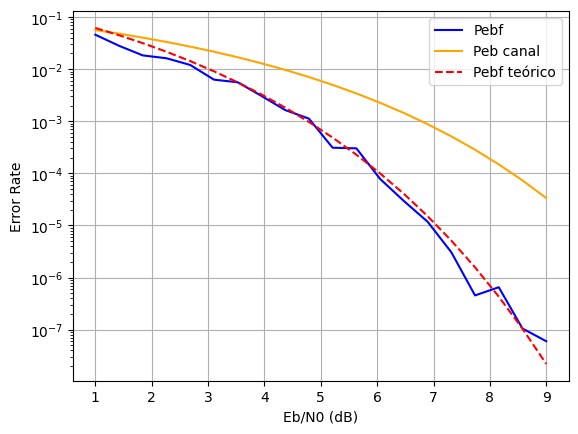

In [38]:
# Plots for corrector code

Peb = 0.5 * erfc(np.sqrt(EbN0))  # Q(x) = 0.5*erfc(x/sqrt(2))
Pew = comb(n, tc+1) * Peb**(tc+1) # (assuming independent bit errors and p << 1)
Pebf = ((2*tc+1)/ n) * Pew # (using valid approximation)

plt.semilogy(EbN0_dB, source_ber, 'b-', label='Pebf')
plt.semilogy(EbN0_dB, Peb, '-', color='orange', label='Peb canal')
plt.semilogy(EbN0_dB, Pebf, 'r--', label='Pebf teórico')

plt.plot(figsize=(14,6))
plt.grid(True)
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Error Rate')
plt.yscale('log')
plt.legend()
plt.show()

In [27]:
# Detector code

steps = 10
EbN0_dB = np.linspace(0, 8, steps)
EbN0 = 10**(EbN0_dB/10)  # Convert to linear scale

EbfN0 = EbN0 * n/k
EbfN0_dB = 10 * np.log10(EbfN0)

# Simulate error rates for coded and uncoded system, only with error detection
coded_wer = np.zeros(steps)  # Coded word error rate

for i, ebf_n0 in enumerate(EbfN0):
    trials = 10 / (0.5 * erfc(np.sqrt(ebf_n0))) # Thumbnail rule to reach a good approximation with dynamic trials
    trials = int(trials)
    print("trials(ebf_n0)", ebf_n0, trials)

    attempts = 0
    while coded_wer[i] == 0: 
        print(attempts)
        source_messages = np.random.randint(0, 2, (trials, k))

        encoded_messages = np.array([encode_message(msg, G) for msg in source_messages])
        received_codewords = noisy_channel(encoded_messages, n=n, k=k, EbfN0=ebf_n0)
        
        # Considering the detectable syndromes, we want to count how many errors are undetected
        syndromes = np.dot(received_codewords, H.T) % 2

        # Find indices where syndrome is all zeros (no errors detected)
        detected = ~np.any(syndromes, axis=1)  # True for undetected errors

        # Get only the undetected error cases
        Ve = received_codewords[detected]  # Received codewords with undetected errors
        U = source_messages[np.where(detected)[0]]      # Original source messages for undetected errors
        
        # if len(Ve) > 0:  # Only process if there are undetected errors
        Ue = Ve[:, :k]                      # First k bits of received codewords
        E = U != Ue                         # Bit differences
        bit_differences = np.sum(E, axis=1)  # Sum of bit errors per word
        word_errors = (bit_differences > 0).astype(float)  # Word errors
        bit_errors = bit_differences / k     # Bit error rates
        
        coded_wer[i] = np.mean(word_errors)
        attempts += 1
        if attempts == 300:
            break


trials(ebf_n0) 1.4 212
0
trials(ebf_n0) 1.717975335791666 313
0
1
2
trials(ebf_n0) 2.108170895991777 499
0
trials(ebf_n0) 2.5869897163912072 872
0
1
2
3
trials(ebf_n0) 3.1745603762191217 1703
0
1
2
3
4
5
6
7
8
9
10
11
trials(ebf_n0) 3.895583163089975 3809
0
trials(ebf_n0) 4.780368423367042 10061
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
trials(ebf_n0) 5.8661107481013355 32558
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
trials(ebf_n0) 7.198452558757495 135093
0
1
2
3
4
5
6
7
8
9
10


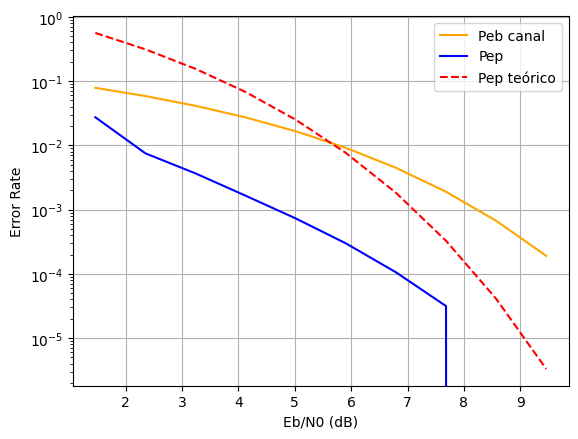

In [28]:
# Plots for corrector code

Peb = 0.5 * erfc(np.sqrt(EbN0))  # Q(x) = 0.5*erfc(x/sqrt(2))
Pew = comb(n, tc+1) * Peb**(tc+1) # (assuming independent bit errors and p << 1)

plt.semilogy(EbfN0_dB, Peb, '-', color='orange', label='Peb canal')
plt.semilogy(EbfN0_dB, coded_wer, 'b-', label='Pep')
plt.semilogy(EbfN0_dB, Pew, 'r--', label='Pep teórico')

plt.plot(figsize=(14,6))
plt.grid(True)
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Error Rate')
plt.yscale('log')
plt.legend()
plt.show()